In [1]:
from yellowbrick.cluster import KElbowVisualizer
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import datetime as dt

import warnings
warnings.simplefilter(action="ignore")

# Loading the Dataset

In [2]:
df_ = pd.read_csv("/kaggle/input/flo-data/FLO.csv")
df = df_.copy()

# Adjusting Row Column Settings

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#  Exploratory Data Analysis

In [4]:
def data_review(dataframe):
    print("**********head**********")
    print(dataframe.head())
    print("**********isna**********")
    print(dataframe.isnull().sum())
    print("**********shape*********")
    print(dataframe.shape)
    print("*********info***********")
    print(dataframe.info())
    print("*********describe*******")
    print(dataframe.describe().T)
    print("*********nuniq*******")
    print(dataframe.nunique())

data_review(df)

**********head**********
                                           master_id order_channel  \
0               cc294636-19f0-11eb-8d74-000d3a38a36f   Android App   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android A...           NaN   
2  69b69676-1a40-11ea-941b-000d3a38a36f,Android A...           NaN   
3  1854e56c-491f-11eb-806e-000d3a38a36f,Android A...           NaN   
4               d6ea1074-f1f5-11e9-9346-000d3a38a36f       Desktop   

  last_order_channel first_order_date last_order_date last_order_date_online  \
0            Offline       2020-10-30      2021-02-26             2021-02-21   
1                NaN              NaN             NaN                    NaN   
2                NaN              NaN             NaN                    NaN   
3                NaN              NaN             NaN                    NaN   
4            Desktop       2019-08-03      2021-03-07             2021-03-07   

  last_order_date_offline  order_num_total_ever_online  \
0              

In [5]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    numeric_df = df.select_dtypes(include='number')
    # quantile() işlemi
    quantiles = numeric_df.describe([0, 0.05, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 1]).T
    print(quantiles)

In [6]:
check_df(df)

##################### Shape #####################
(19945, 12)
##################### Types #####################
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object
##################### Head #####################
                                           master_id order_channel  \
0               cc294636-19f0-11eb-8d74-000d3a38a36f   Android App   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android A...           NaN   
2  69b69676-1a40-11ea-941b-000d3a38a36f,Android A...           NaN   
3  18

# Convert Date Columns to DateTime

In [7]:

date_columns = [col for col in df.columns if 'date' in col.lower()]
for col in date_columns:
    df[col] = pd.to_datetime(df[col])

# Capturing / Detecting Numeric and Categorical Variables

In [8]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note Categorical variables include categorical variables with numeric appearance.

    Parameters
    ------
        dataframe: dataframe
                Variable names of the dataframe to be taken
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                List of cardinal variables with categorical appearance

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols.
        The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')


    return cat_cols, num_cols, cat_but_car, num_but_cat

In [9]:
cat_cols, num_cols, cat_but_car,  num_but_cat = grab_col_names(df)

Observations: 19945
Variables: 12
cat_cols: 3
num_cols: 8
cat_but_car: 1
num_but_cat: 0


In [10]:
cat_cols

['order_channel', 'last_order_channel', 'interested_in_categories_12']

In [11]:
num_cols

['first_order_date',
 'last_order_date',
 'last_order_date_online',
 'last_order_date_offline',
 'order_num_total_ever_online',
 'order_num_total_ever_offline',
 'customer_value_total_ever_offline',
 'customer_value_total_ever_online']

In [12]:
cat_but_car

['master_id']

In [13]:
num_but_cat

[]

# Analysis of Categorical Variables

In [14]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe, palette="Set2")
        plt.show(block=True)

               order_channel  Ratio
order_channel                      
Android App             4858 24.357
Mobile                  3097 15.528
Desktop                 1742  8.734
Ios App                 1548  7.761
##########################################


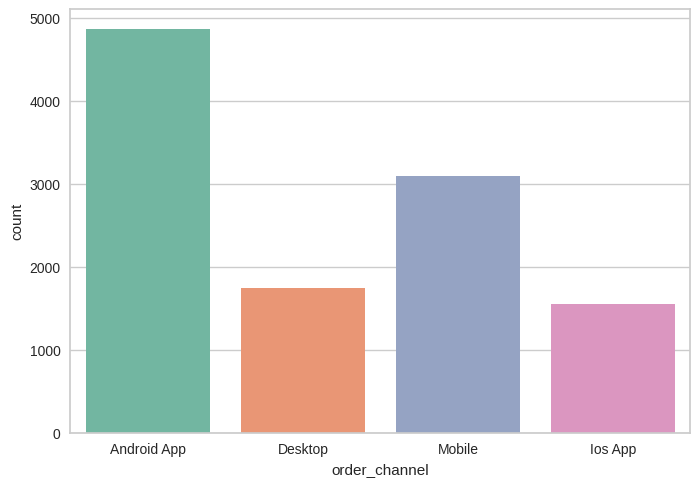

                    last_order_channel  Ratio
last_order_channel                           
Android App                       3613 18.115
Offline                           3528 17.689
Mobile                            2086 10.459
Desktop                           1017  5.099
Ios App                           1001  5.019
##########################################


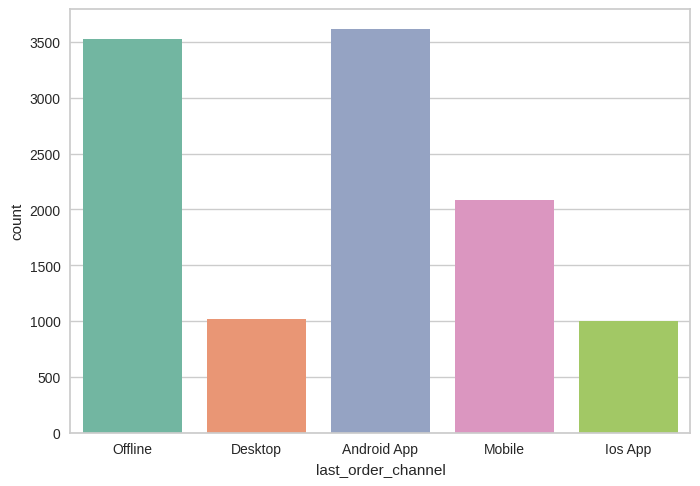

                             interested_in_categories_12  Ratio
interested_in_categories_12                                    
[AKTIFSPOR]                                         3464 17.368
[KADIN]                                             2158 10.820
[]                                                  2135 10.704
[ERKEK]                                             1973  9.892
[COCUK]                                              836  4.192
[AKTIFCOCUK]                                         679  3.404
##########################################


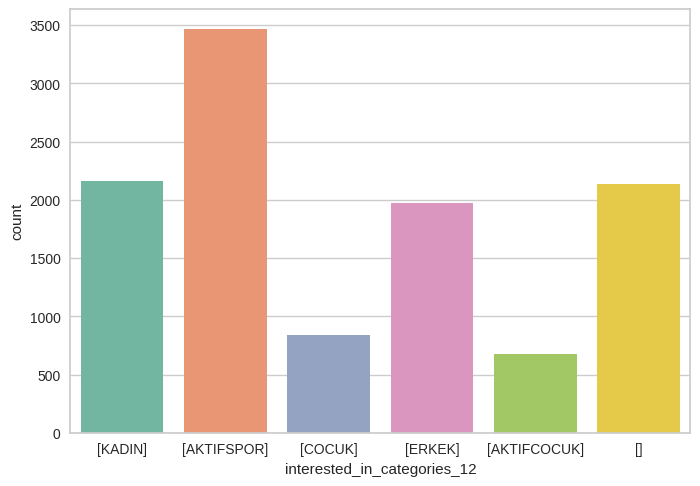

In [15]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

# Analysis of Numerical Variables

In [16]:
def num_summary(dataframe, col_name, plot=False):
    quantiles = [0.05, 0.10,0.40, 0.50, 0.80, 0.90, 0.95]
    print(dataframe[col_name].describe(quantiles).T)

    if plot:
        sns.histplot(data=dataframe, x=col_name, bins=20, kde=True, color="blue")
        plt.show(block=True)

count                            11245
mean     2019-03-22 11:48:24.650955776
min                2013-01-27 00:00:00
5%                 2015-11-04 09:36:00
10%                2017-04-24 09:36:00
40%                2019-06-08 00:00:00
50%                2019-08-17 00:00:00
80%                2020-01-16 00:00:00
90%                2020-05-01 14:24:00
95%                2020-09-19 00:00:00
max                2021-05-27 00:00:00
Name: first_order_date, dtype: object


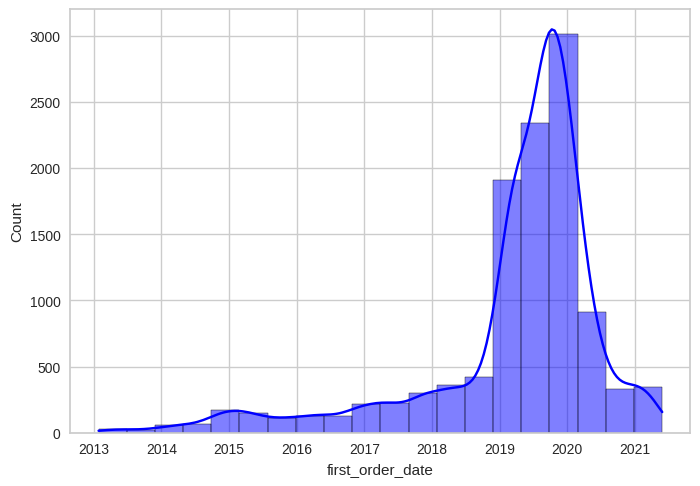

count                            11245
mean     2021-01-12 19:07:23.397065216
min                2020-05-30 00:00:00
5%                 2020-06-25 00:00:00
10%                2020-07-20 00:00:00
40%                2020-12-29 00:00:00
50%                2021-02-06 00:00:00
80%                2021-05-01 00:00:00
90%                2021-05-15 00:00:00
95%                2021-05-23 00:00:00
max                2021-05-30 00:00:00
Name: last_order_date, dtype: object


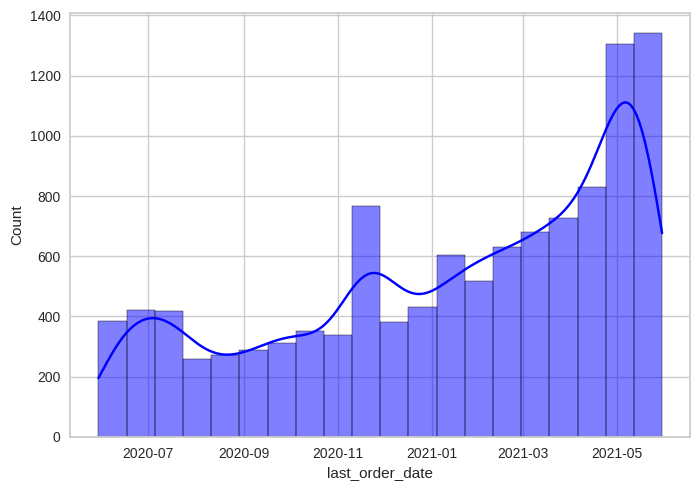

count                            11245
mean     2020-07-15 13:40:58.372610048
min                2014-02-24 00:00:00
5%                 2017-12-07 00:00:00
10%                2019-02-09 09:36:00
40%                2020-10-13 00:00:00
50%                2020-12-01 00:00:00
80%                2021-04-25 00:00:00
90%                2021-05-10 00:00:00
95%                2021-05-20 00:00:00
max                2021-05-30 00:00:00
Name: last_order_date_online, dtype: object


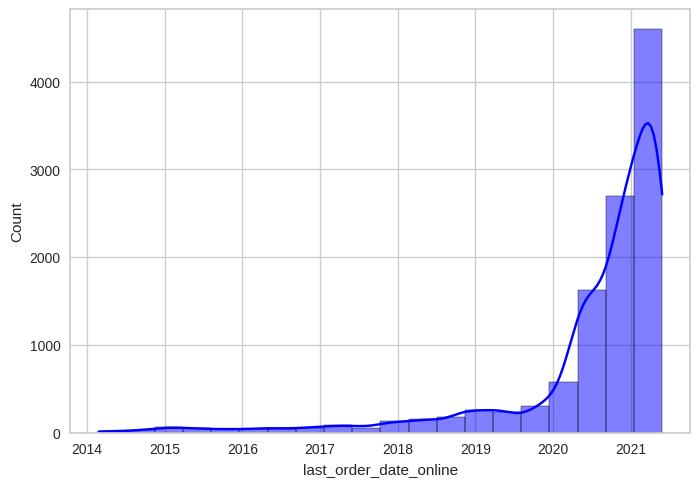

count                            11245
mean     2020-04-05 21:13:46.927523328
min                2019-01-29 00:00:00
5%                 2019-03-27 00:00:00
10%                2019-07-09 00:00:00
40%                2019-12-16 00:00:00
50%                2020-02-04 00:00:00
80%                2021-01-15 00:00:00
90%                2021-03-19 00:00:00
95%                2021-04-14 00:00:00
max                2021-05-28 00:00:00
Name: last_order_date_offline, dtype: object


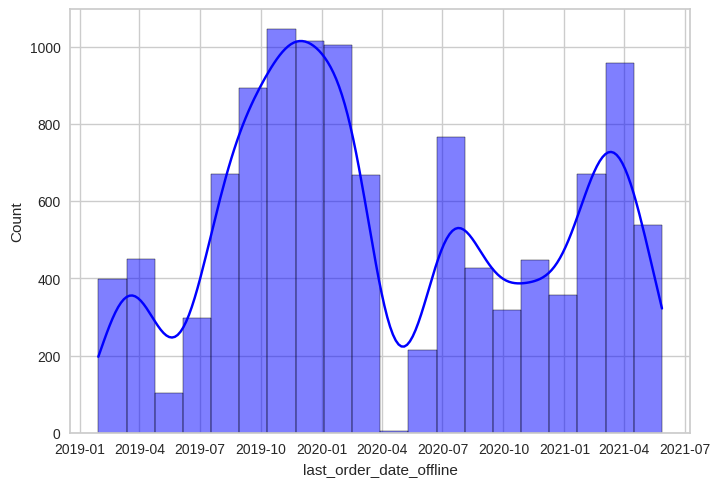

count   11245.000
mean        2.358
std         2.671
min         1.000
5%          1.000
10%         1.000
40%         1.000
50%         1.000
80%         3.000
90%         5.000
95%         7.000
max        49.000
Name: order_num_total_ever_online, dtype: float64


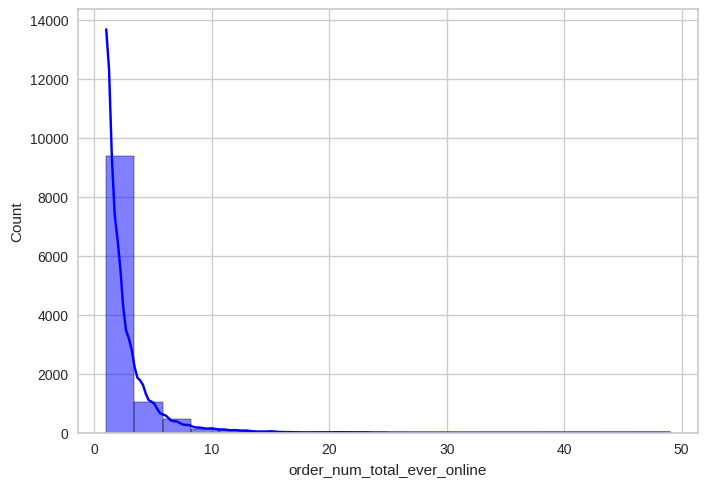

count   11245.000
mean        1.661
std         1.629
min         1.000
5%          1.000
10%         1.000
40%         1.000
50%         1.000
80%         2.000
90%         3.000
95%         4.000
max        87.000
Name: order_num_total_ever_offline, dtype: float64


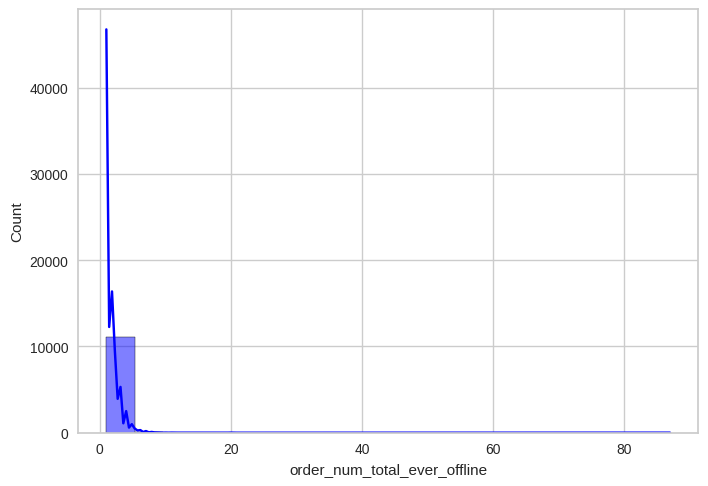

count   11245.000
mean      216.776
std       274.529
min        10.000
5%         39.990
10%        59.980
40%       129.970
50%       155.860
80%       309.970
90%       430.956
95%       579.966
max     18119.140
Name: customer_value_total_ever_offline, dtype: float64


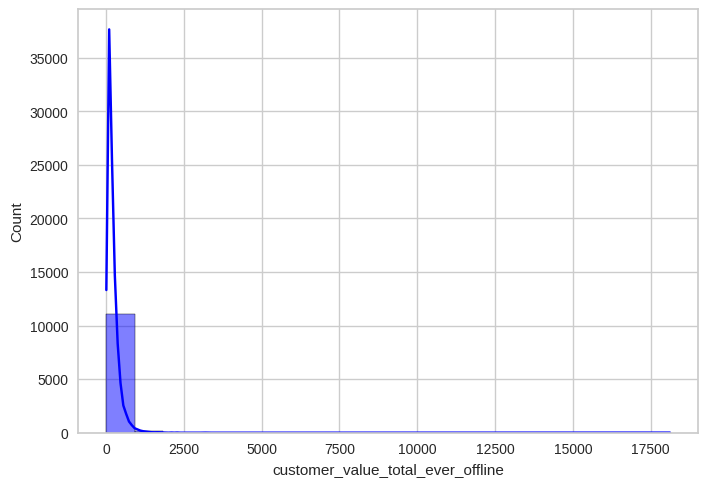

count   11245.000
mean      360.535
std       431.211
min        14.990
5%         59.990
10%        76.990
40%       180.772
50%       229.900
80%       503.982
90%       770.208
95%      1079.882
max      8667.730
Name: customer_value_total_ever_online, dtype: float64


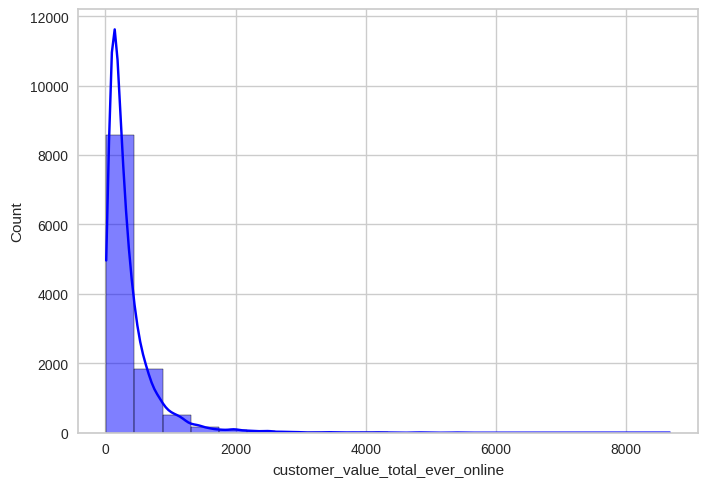

In [17]:
for col in num_cols:
    num_summary(df, col, plot=True)

# Correlation Analysis

In [18]:
corr = df[num_cols].corr()
corr

,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online
first_order_date,1.000,1.000,1.000,1.000,-0.376,-0.071,-0.024,-0.213
last_order_date,1.000,1.000,1.000,1.000,0.032,0.011,0.036,0.067
last_order_date_online,1.000,1.000,1.000,1.000,0.084,-0.046,-0.053,0.149
last_order_date_offline,1.000,1.000,1.000,1.000,-0.089,0.151,0.191,-0.110
order_num_total_ever_online,-0.376,0.032,0.084,-0.089,1.000,0.005,-0.010,0.823
order_num_total_ever_offline,-0.071,0.011,-0.046,0.151,0.005,1.000,0.584,-0.001
customer_value_total_ever_offline,-0.024,0.036,-0.053,0.191,-0.010,0.584,1.000,0.052
customer_value_total_ever_online,-0.213,0.067,0.149,-0.110,0.823,-0.001,0.052,1.000


In [19]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    # Only numerical columns
    numeric_df = dataframe.select_dtypes(include=[np.number])

    # Correlation matrix
    corr = numeric_df.corr()
    cor_matrix = corr.abs()

    # Select upper triangular matrix (to remove unnecessary repetitions)
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))

    # Let's select the column pairs whose correlation is higher than the threshold
    high_corrs = [(col, row)
                  for col in cor_matrix.columns
                  for row in cor_matrix.index
                  if not pd.isna(upper_triangle_matrix.loc[row, col]) and abs(
            upper_triangle_matrix.loc[row, col]) > corr_th]

    if plot:
        # Heatmap
        plt.figure(figsize=(10, 6))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu")
        plt.title("Correlation Heat Map")
        plt.show()

    return high_corrs

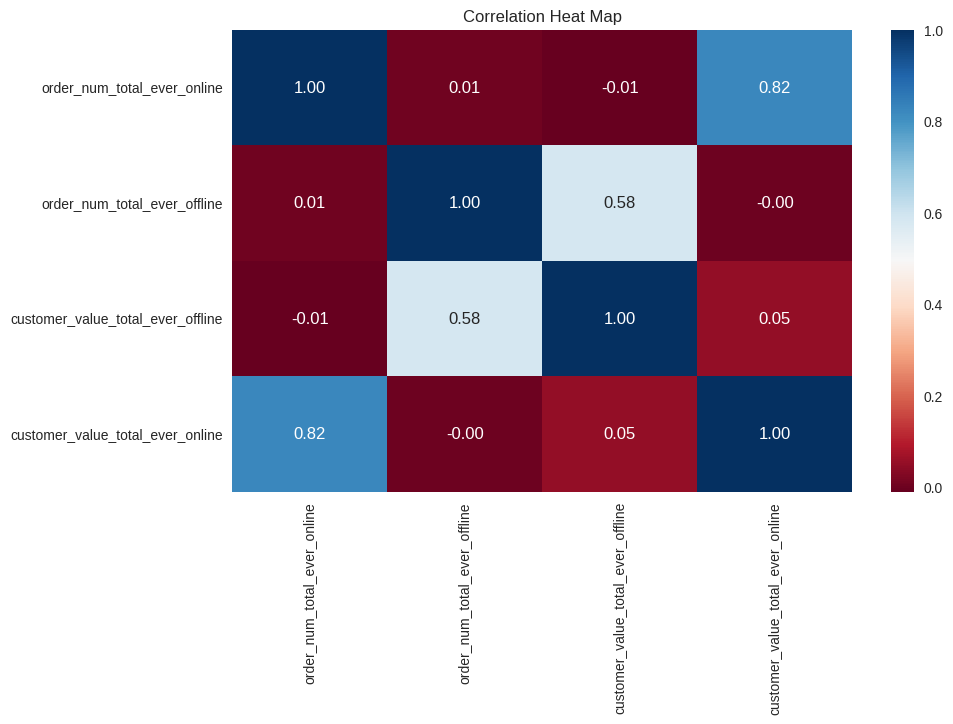

[('customer_value_total_ever_online', 'order_num_total_ever_online')]

In [20]:
high_correlated_cols(df, plot=True)

# Feature Engineering


*  Missing Values Detection** 
*  Outlier Detection (Outliers)
*  Feature Extraction


# Missing Value Analysis

In [21]:
df.isnull().sum()

master_id                               0
order_channel                        8700
last_order_channel                   8700
first_order_date                     8700
last_order_date                      8700
last_order_date_online               8700
last_order_date_offline              8700
order_num_total_ever_online          8700
order_num_total_ever_offline         8700
customer_value_total_ever_offline    8700
customer_value_total_ever_online     8700
interested_in_categories_12          8700
dtype: int64

# Outlier Analysis

In [22]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [23]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [24]:
for col in num_cols:
    print(col, check_outlier(df, col))

first_order_date False
last_order_date False
last_order_date_online False
last_order_date_offline False
order_num_total_ever_online True
order_num_total_ever_offline True
customer_value_total_ever_offline True
customer_value_total_ever_online True


In [25]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [26]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [27]:
for col in num_cols:
    print(col, check_outlier(df, col))

first_order_date False
last_order_date False
last_order_date_online False
last_order_date_offline False
order_num_total_ever_online False
order_num_total_ever_offline False
customer_value_total_ever_offline False
customer_value_total_ever_online False


# Feature Extraction

In [28]:
today_date = df["last_order_date"].max() + dt.timedelta(days=2)

In [29]:
# Create Total Spending and Order Count Features
df["Total_Value"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]
df["Total_Order"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]

In [30]:
# Calculate RFM Metrics
rfm = df.groupby('master_id').agg({
    'last_order_date': lambda x: (today_date - x.max()).days,  # Recency
    'Total_Order': 'sum',                                          # Frequency
    'Total_Value': 'sum',                                           # Monetary
    'first_order_date': lambda x: (today_date - x.max()).days   # Tenure
}).reset_index()

rfm.columns = ['master_id', 'recency', 'frequency', 'monetary', 'Tenure']

In [31]:
df = pd.merge(df, rfm, on="master_id")

In [32]:
df['New_Avg_Orders_Per_Day'] = df["Total_Order"] / df['Tenure']

In [33]:
df.columns = [col.upper() for col in df.columns]

In [34]:
df.head()

,MASTER_ID,ORDER_CHANNEL,LAST_ORDER_CHANNEL,FIRST_ORDER_DATE,LAST_ORDER_DATE,LAST_ORDER_DATE_ONLINE,LAST_ORDER_DATE_OFFLINE,ORDER_NUM_TOTAL_EVER_ONLINE,ORDER_NUM_TOTAL_EVER_OFFLINE,CUSTOMER_VALUE_TOTAL_EVER_OFFLINE,CUSTOMER_VALUE_TOTAL_EVER_ONLINE,INTERESTED_IN_CATEGORIES_12,TOTAL_VALUE,TOTAL_ORDER,RECENCY,FREQUENCY,MONETARY,TENURE,NEW_AVG_ORDERS_PER_DAY
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN],939.370,5.000,95.000,5.000,939.370,214.000,0.023
1,"f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android A...",NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN
2,"69b69676-1a40-11ea-941b-000d3a38a36f,Android A...",NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN
3,"1854e56c-491f-11eb-806e-000d3a38a36f,Android A...",NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR],209.980,2.000,86.000,2.000,209.980,668.000,0.003


# Standardization Process¶

In [35]:
cat_cols, num_cols, cat_but_car,  num_but_cat = grab_col_names(df)

Observations: 19945
Variables: 19
cat_cols: 4
num_cols: 14
cat_but_car: 1
num_but_cat: 1


In [36]:
cat_cols

['ORDER_CHANNEL',
 'LAST_ORDER_CHANNEL',
 'INTERESTED_IN_CATEGORIES_12',
 'ORDER_NUM_TOTAL_EVER_OFFLINE']

In [37]:
num_cols

['FIRST_ORDER_DATE',
 'LAST_ORDER_DATE',
 'LAST_ORDER_DATE_ONLINE',
 'LAST_ORDER_DATE_OFFLINE',
 'ORDER_NUM_TOTAL_EVER_ONLINE',
 'CUSTOMER_VALUE_TOTAL_EVER_OFFLINE',
 'CUSTOMER_VALUE_TOTAL_EVER_ONLINE',
 'TOTAL_VALUE',
 'TOTAL_ORDER',
 'RECENCY',
 'FREQUENCY',
 'MONETARY',
 'TENURE',
 'NEW_AVG_ORDERS_PER_DAY']

In [38]:
cat_but_car

['MASTER_ID']

In [39]:
num_but_cat

['ORDER_NUM_TOTAL_EVER_OFFLINE']

In [40]:
num_cols2 = [col for col in num_cols if col not in ['FIRST_ORDER_DATE',
 'LAST_ORDER_DATE',
 'LAST_ORDER_DATE_ONLINE',
 'LAST_ORDER_DATE_OFFLINE']]

In [41]:
df[num_cols2].astype(float)

,ORDER_NUM_TOTAL_EVER_ONLINE,CUSTOMER_VALUE_TOTAL_EVER_OFFLINE,CUSTOMER_VALUE_TOTAL_EVER_ONLINE,TOTAL_VALUE,TOTAL_ORDER,RECENCY,FREQUENCY,MONETARY,TENURE,NEW_AVG_ORDERS_PER_DAY
0,4.000,139.990,799.380,939.370,5.000,95.000,5.000,939.370,214.000,0.023
1,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN
4,1.000,49.990,159.990,209.980,2.000,86.000,2.000,209.980,668.000,0.003
...,...,...,...,...,...,...,...,...,...,...
19940,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN
19941,1.000,150.480,239.990,390.470,2.000,161.000,2.000,390.470,457.000,0.004
19942,2.000,139.980,492.960,632.940,3.000,8.000,3.000,632.940,629.000,0.005
19943,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN


In [42]:
scaler = StandardScaler()

In [43]:
df_scaled = scaler.fit_transform(df[num_cols2])


# Encoding Operations

In [44]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [45]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_)

Observations: 19945
Variables: 12
cat_cols: 3
num_cols: 4
cat_but_car: 5
num_but_cat: 0


In [46]:
num_cols

['order_num_total_ever_online',
 'order_num_total_ever_offline',
 'customer_value_total_ever_offline',
 'customer_value_total_ever_online']

In [47]:
cat_cols

['order_channel', 'last_order_channel', 'interested_in_categories_12']